## Intro
This code shows an example of using OWAD upon abnormal-confidence anomaly detection models (e.g., RMSE of Auto-Encoder). Here we use a NIDS case with `Auto-Encoder` as the anomaly detection model and `Kyoto-2006` as the traffic dataset.

**In this case, we'll show that retraining may have a negative effect when dealing with a "diffcult" shifting case.**


In [7]:
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/admodels/DeepLog.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/calibrator.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/shifthunter.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/myutils.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/configs.yml
!wget https://raw.githubusercontent.com/dongtsi/OWAD/main/admodels/AE.py

--2024-03-29 04:44:28--  https://raw.githubusercontent.com/figaz123/OWAD/main/admodels/DeepLog.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5484 (5.4K) [text/plain]
Saving to: ‘DeepLog.py.1’

DeepLog.py.1        100%[===================>]   5.36K  --.-KB/s    in 0s      

2024-03-29 04:44:28 (61.8 MB/s) - ‘DeepLog.py.1’ saved [5484/5484]

--2024-03-29 04:44:28--  https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/calibrator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4332 (4.2K) [text/plain]
Saving to: ‘cali

In [8]:
%load_ext autoreload
%autoreload 2
## import packages
import sys
sys.path.append('../admodels/')
sys.path.append('../moudles/')
sys.path.append('../baselines/')
sys.path.append('../')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import _pickle as pkl
import AE
from calibrator import Calibrator
from shifthunter import ShiftHunter
import myutils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare AD model and data

In [9]:
## Train an initial anomlay detection model (Auto-Encoder)
utils.set_random_seed()
feat = np.load('2007.npz')
train_num = 50000
X, y = feat['X'], feat['y']
X_ben = X[y==0]
X_train = X_ben[:train_num]
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
model, thres = AE.train(X_train, X_train.shape[-1])

epoch:0/10 |Loss: 0.013792422600090504
epoch:1/10 |Loss: 0.013447402976453304
epoch:2/10 |Loss: 0.013002712279558182
epoch:3/10 |Loss: 0.012609495781362057
epoch:4/10 |Loss: 0.012191148474812508
epoch:5/10 |Loss: 0.011781789362430573
epoch:6/10 |Loss: 0.011332523077726364
epoch:7/10 |Loss: 0.010742061771452427
epoch:8/10 |Loss: 0.009929853491485119
epoch:9/10 |Loss: 0.008891512639820576
max AD score 0.14361233
thres: 0.11106684


Original Performance @2007
roc_auc: 0.947313757


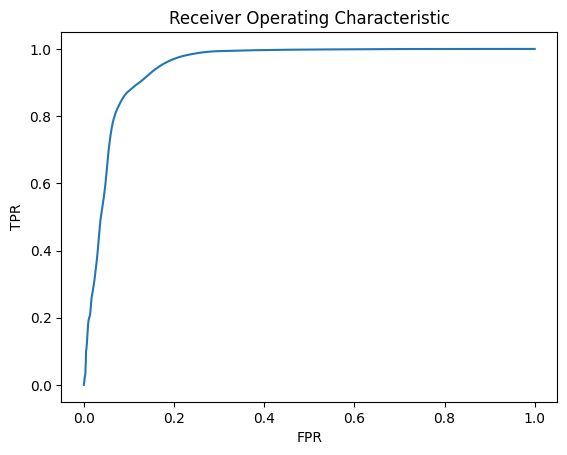

Before Adaptation @2011:
roc_auc: 0.8068434427372765


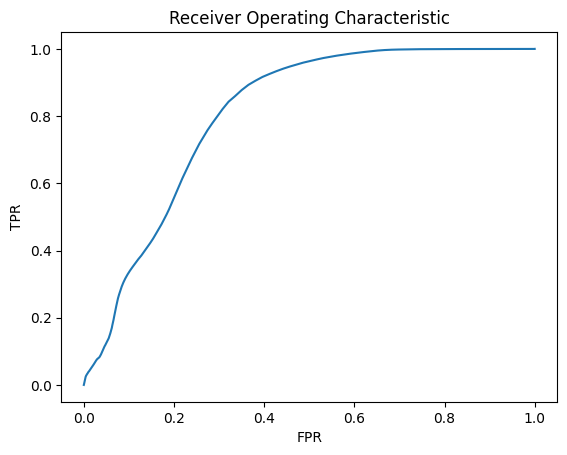

In [10]:
## Load Control (2007) and Treatment (2011) Dataset
%matplotlib inline
FEAT_0 = np.load('2007.npz')
X_0, y_0 = scaler.transform(FEAT_0['X']), FEAT_0['y']

FEAT_1 = np.load('2011.npz')
X_1, y_1 = scaler.transform(FEAT_1['X']), FEAT_1['y']

## Test Original Performance @2007 and @2011
print('Original Performance @2007')
y_pred_0, y_prob_0 = AE.test(model, thres, X_0)
utils.multi_metrics(y_prob_0, y_0, thres*1.5)

print('Before Adaptation @2011:')
y_pred_1, y_prob_1 = AE.test(model, thres, X_1)
utils.multi_metrics(y_prob_1, y_1, thres*1.5)

vali_num = 100000
## Clip validation set for Control and Treatment data
rmse_c = y_prob_0[:vali_num]
rmse_t = y_prob_1[:vali_num]
X_con = X_0[:vali_num]
X_tre = X_1[:vali_num]

**(As we can see that, the performance decreases from 2007 to 2011, i.e, from 0.94 to 0.80)**

## Let's use OWAD！

NOTICE: Initialize OWAD Calibrator Under **Isotonic** Method!
NOTICE: uncalibrated Probs is **MALICIOUS** confidence
NOTICE: Initilize OWAD Shift Handler Under **Tab** Mode!
Shift! P-value is 0.000999000999000999
Visualize Shift:


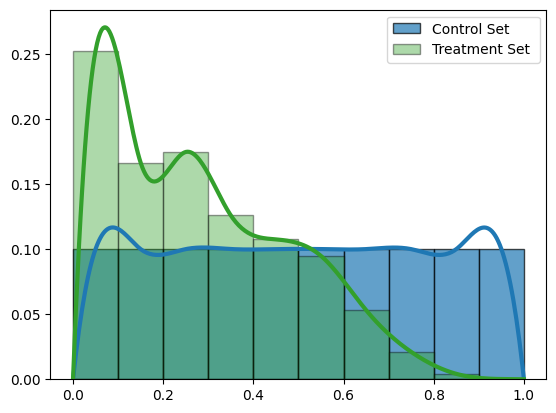

In [11]:
## Detect whether shift happens between 2007 and 2011
utils.set_random_seed()
cb = Calibrator(X_con, method='Isotonic')
cb.set_calibrator(rmse_c, is_P_mal=True)
sh = ShiftHunter(rmse_c, rmse_t, cb, ad_type='Tab')
t = utils.get_params('ShiftDetector')['test_thres']
p_value = sh.permu_test()
if p_value >= t:
    print("Non-shift, skip explain and adaptation!")
else:
    print('Shift! P-value is', p_value)
print("Visualize Shift:")
sh.visualize_hists()

**(As we can see that, OWAD detects shift with full confidence. We can also confirm the shift from the above visualization of calibrated output distribution)**

step:0 |Loss:16.0000 |Accuracy_Loss:1.0000 |Overhead_Loss:1.0000 |Determinism_Loss:1.0000 |M_c num: 50165 |M_t num: 50065
step:10 |Loss:15.3499 |Accuracy_Loss:0.8903 |Overhead_Loss:0.9885 |Determinism_Loss:1.0132 |M_c num: 49713 |M_t num: 49557
step:20 |Loss:14.7962 |Accuracy_Loss:0.7992 |Overhead_Loss:0.9779 |Determinism_Loss:1.0214 |M_c num: 49270 |M_t num: 48845
step:30 |Loss:14.2960 |Accuracy_Loss:0.7182 |Overhead_Loss:0.9679 |Determinism_Loss:1.0257 |M_c num: 48886 |M_t num: 48001
step:40 |Loss:13.8342 |Accuracy_Loss:0.6441 |Overhead_Loss:0.9587 |Determinism_Loss:1.0269 |M_c num: 48427 |M_t num: 47053
step:49 |Loss:13.4419 |Accuracy_Loss:0.5816 |Overhead_Loss:0.9508 |Determinism_Loss:1.0255 |M_c num: 48186 |M_t num: 46115
** Cliping <remain_X_t> ...
NOTICE: simulating labelling...
Filter 0 anomalies in remain_X_tre
Remain X_c.shape (51855, 497) X_t.shape (20000, 497)
Adapter: Begin Processing ... 
 Estimating Params Weight:0/7186
 Estimating Params Weight:2000/7186
 Estimating Par

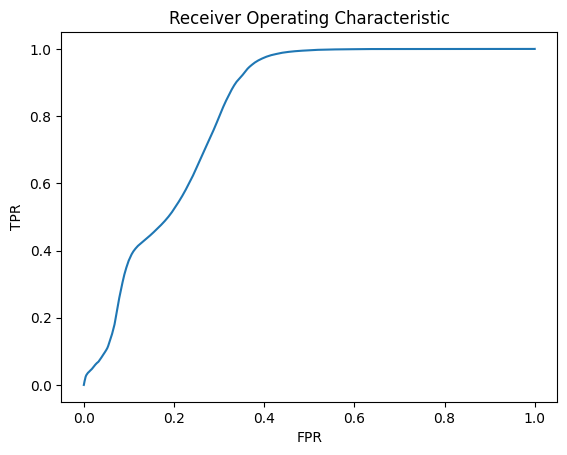

In [12]:
## Shift explanation and adaptation
utils.set_random_seed()
ohd_bgt = 20000
exp_result = sh.explainer(X_tre, y_1[:vali_num], label_num = ohd_bgt) # , auto_cali_thres=True
sh.adapter(model)

## Test the performance after OWAD adaptation
print('After OWAD Adaptation @2011:')
y_pred, y_prob = AE.test(sh.model, thres, X_1)
utils.multi_metrics(y_prob, y_1, thres*1.5)

**(As we can see that, OWAD Adaptation improves the performance of AD models from 0.80 to 0.81 with 20k labels, which is 20% of validation set and 2.5% of testing set)**

**The improvment seems limited in this case. Please see the retraining below**

## What about using retraining?
A common practice to tackle concept drift is to retrain the model with BOTH OLD and NEW samples. Here we'll show whether retraining works in this example.

epoch:0/10 |Loss: 0.013466667383909225
epoch:1/10 |Loss: 0.012857947498559952
epoch:2/10 |Loss: 0.012408431619405746
epoch:3/10 |Loss: 0.011958494782447815
epoch:4/10 |Loss: 0.011251994408667088
epoch:5/10 |Loss: 0.010313482955098152
epoch:6/10 |Loss: 0.009157833643257618
epoch:7/10 |Loss: 0.008101913146674633
epoch:8/10 |Loss: 0.007246534805744886
epoch:9/10 |Loss: 0.007424632087349892
max AD score 0.14939979
thres: 0.119855635
After Retraining:
roc_auc: 0.8442984537717848


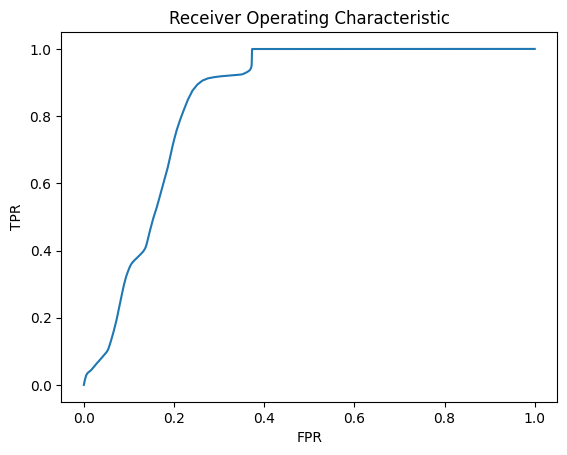

In [13]:
## retraining with all old samples and `ohd_bgt` new samples
utils.set_random_seed()
X_retrain = np.concatenate((X_0[:train_num],X_1[:ohd_bgt]))
retrain_model, retrain_thres = AE.train(X_retrain, X_retrain.shape[-1])

## test the performance of retraining model
print('After Retraining:')
y_pred, y_prob = AE.test(retrain_model, retrain_thres, X_1)
utils.multi_metrics(y_prob, y_1, retrain_thres*1.5)

**(As we can see that, Retraining actually has a negtive effect. Please refer to our paper for more analysis)**